# Loading the data and initial preparation

In [5]:
import pandas as pd
import numpy as np


#Load the data
df = pd.read_csv('Walmart.csv')

#Make a copy 
df_copy = df.copy()

#Move from data-frame to numpy array
data_complete=df_copy.to_numpy()

#Keep the column names (without "date")  
col_names=df_copy.columns.values.tolist()

#Print columns
print(col_names)



['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


# Exploring the data

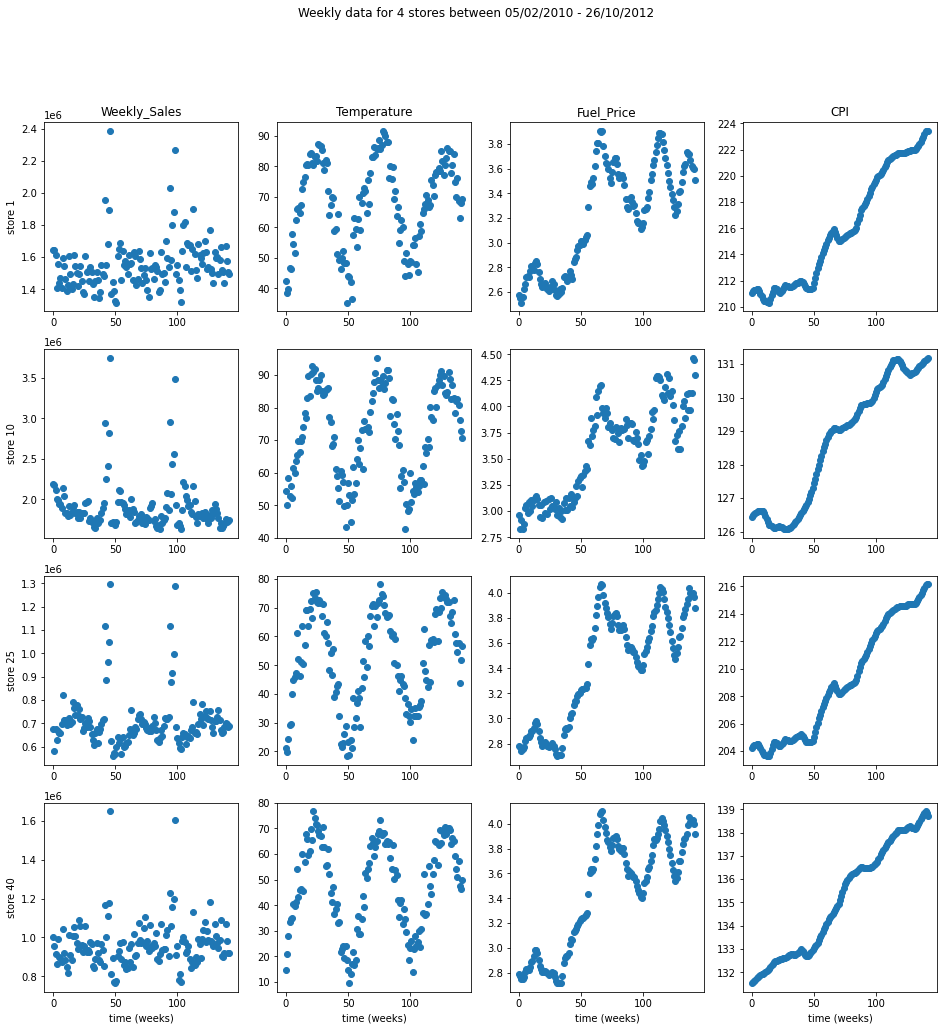

In [33]:
#Plot some of the input variables for some of the stores

import matplotlib.pyplot as plt

fig, axs=plt.subplots(4,4, figsize=(16,16)) #4 stores (in rows) and 4 input variables (in columns) for each
for i, store in enumerate([1, 10, 25, 40]):  #store numbers
    data_one_store = data_complete[data_complete[:, 0] == store]
    for ii, var in enumerate([2,4,5,6]):  #column numbers of the 4 input variables
        axs[i,ii].plot(range(143),data_one_store[:,var],'o')
        if i==0:
            axs[i, ii].set_title(col_names[var])
        if ii==0:
            axs[i, ii].set_ylabel('store '+ str(store))
        if i==3:
            axs[i,ii].set_xlabel('time (weeks)')

fig.suptitle('Weekly data for 4 stores between 05/02/2010 - 26/10/2012')
plt.show()

# Normalize the data

In [8]:
#Normalise the data to be in the range 0-1.  

#Remove the store and date columns before normalization
data_for_normalization=data_complete[:,2:] 

#Normalise the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_for_normalization = scaler.fit_transform(data_for_normalization)

#Check
print(np.max(data_for_normalization, axis=0))
print(np.min(data_for_normalization, axis=0))     

[1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0.]


# Prepare the data for training

In [9]:
#This model will use only the sales as input variable
#It's a time series of length 143 for each of the 45 stores.
#142 data points are used as the input variable (x) and 1 data point is used as the label (y).
#36 stores are used for training and 9 stores for testing 

#Take only the sales column
data=data_for_normalization[:,0]

#Make the labels (y)
y=data[142::143]

#Make the input variable (x)
mask = np.ones_like(data, dtype=bool)
mask[142::143] = False
x = data[mask]

#Reshape x and y (as needed to input to the model)
x=x.reshape(45,142,1)   # (num_stores,seq_length,num_input_variable)
y=y.reshape(45,1,1)

#Train/Test split
x_train, x_test, y_train, y_test=x[:36,:,:], x[36:,:,:], y[:36,:,:], y[36:,:,:]


# The RNN Model 

In [10]:
#The model already includes LSTM (long short-term memory) layers instead of simple RNN layers to improve the "memory" of the
#model (effect of early points in the time series on the label).

#The loss function is mean-square error (mse)


import tensorflow as tf
from tensorflow import keras


#Define R2-score metric
def r2_score(y_true, y_pred):
    y_diff = tf.reduce_sum(tf.square(y_true-y_pred))
    y_square = tf.reduce_sum(tf.square(y_true-tf.reduce_mean(y_true)))
    return 1-y_diff/y_square


#Model with LSTM layers
model = keras.models.Sequential()
model.add(keras.layers.LSTM(20, return_sequences=True, input_shape=[142, 1]))
model.add(keras.layers.LSTM(100, return_sequences=True))
model.add(keras.layers.LSTM(2, return_sequences=False))
model.add(keras.layers.Dense(100, activation='tanh'))
model.add(keras.layers.Dense(20, activation='tanh'))
model.add(keras.layers.Dense(1))


optimizer = keras.optimizers.SGD(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer, metrics=r2_score)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 142, 20)           1760      
                                                                 
 lstm_1 (LSTM)               (None, 142, 100)          48400     
                                                                 
 lstm_2 (LSTM)               (None, 2)                 824       
                                                                 
 dense (Dense)               (None, 100)               300       
                                                                 
 dense_1 (Dense)             (None, 20)                2020      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 53,325
Trainable params: 53,325
Non-traina

# Training the model

In [14]:
#Next line to train the model (muted since training was already done and the results were saved)
#model.fit(x_train, y_train, epochs=500, batch_size=10, validation_data=(x_test, y_test))


#Load saved model and its history object
import pickle
saved_model=tf.keras.models.load_model('model4b',custom_objects={'r2_score': r2_score})
with open('model4b/trainHistoryDict', "rb") as file_pi:
   saved_history = pickle.load(file_pi)

# Plot R2 from train and test data

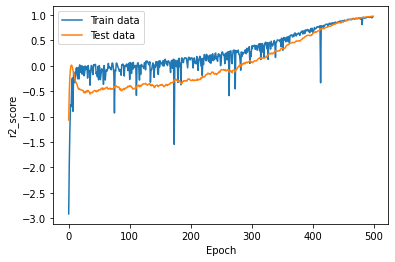

R2 train: 0.9655580520629883
R2 validiation: 0.9737773537635803


In [17]:
#Plot using the "saved_history" from the saved results of training 

plt.plot(saved_history['r2_score'], label='Train data')
plt.plot(saved_history['val_r2_score'], label='Test data')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('r2_score')
plt.show()

#Print R2 values at the end of training
print(f"R2 train: {saved_history['r2_score'][-1]}")
print(f"R2 validiation: {saved_history['val_r2_score'][-1]}")

# Make predictions using the model

1/1 [==============================] - 0s 45ms/step


Text(0.5, 0, 'time (weeks)')

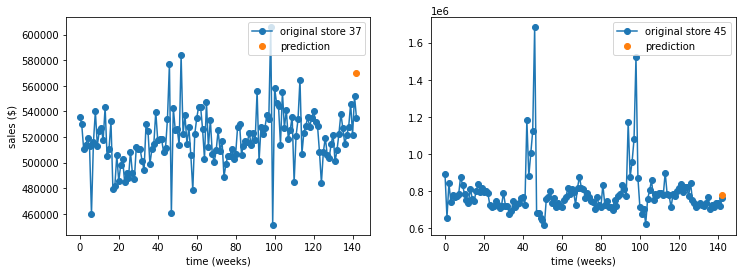

In [31]:
#Make prediction for a couple of stores

store=[37,45]
store_ind=[0,8]  # 0-8 correspond to stores 37-45

y_real=y_test
y_pred=saved_model.predict(x_test)


#Back normalization (to return to original range)
y_pred=y_pred*scaler.data_range_[0] + scaler.data_min_[0] #recovers x from: x_norm=(x-x.min)/(x.max-x.min)

#Plot prediction for the two stores
fig, xs=plt.subplots(1,2,figsize=(12,4))

#Store 37
xs[0].plot(range(143), data[data_complete[:,0]==store[0]]*scaler.data_range_[0] + scaler.data_min_[0],'-o'
         ,label='original store '+str(store[0]))
xs[0].plot(142,y_pred[store_ind[0]],'o',label='prediction')
xs[0].legend()
xs[0].set_xlabel('time (weeks)')
xs[0].set_ylabel('sales ($)')

#Store 45
xs[1].plot(range(143), data[data_complete[:,0]==store[1]]*scaler.data_range_[0] + scaler.data_min_[0],'-o'
         ,label='original store '+str(store[1]))
xs[1].plot(142,y_pred[store_ind[1]],'o',label='prediction')
xs[1].legend()
xs[1].set_xlabel('time (weeks)')
